In [4]:
from numba import cuda
cuda.current_context()


<CUDA context c_void_p(96953415181504) of device 0>

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from numba import cuda

@cuda.jit
def julia_kernel(c, xlim, ylim, max_iter, output):
    # Compute the position of the thread in the output array
    height, width = output.shape
    x, y = cuda.grid(2)

    if x < width and y < height:
        z = complex(xlim[0] + (xlim[1] - xlim[0]) * x / width,
                     ylim[0] + (ylim[1] - ylim[0]) * y / height)
        n = 0

        while abs(z) < 2 and n < max_iter:
            z = z * z + c
            n += 1

        output[y, x] = n


def julia_set_on_gpu(c, xlim, ylim, desired_width=1000, max_iterations=300):
    output_device = cuda.device_array((desired_width, desired_width), dtype=np.int32)

    # Set up grid and block sizes
    threads_per_block = (16, 16)
    blocks_per_grid_x = (desired_width + (threads_per_block[0] - 1)) // threads_per_block[0]
    blocks_per_grid_y = (desired_width + (threads_per_block[1] - 1)) // threads_per_block[1]

    # Launch the kernel
    julia_kernel[(blocks_per_grid_x, blocks_per_grid_y), threads_per_block](c, xlim, ylim, max_iterations, output_device)

    return output_device.copy_to_host()



In [40]:
import timeit
c=-0.62772-0.42193j
xlim = (-1.8, 1.8)  # Range for the x-axis
ylim = (-1.8, 1.8)

%timeit output = julia_set_on_gpu(c, xlim, ylim)



12.5 ms ± 574 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


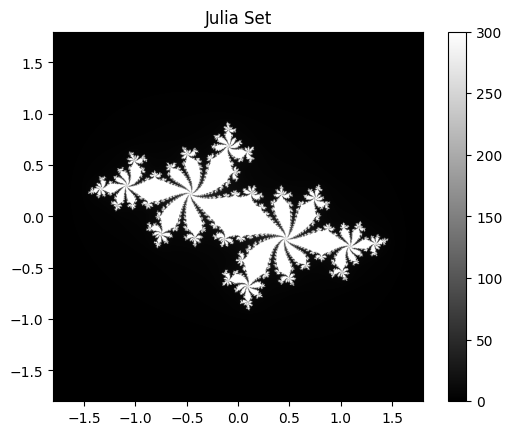

In [41]:
# Plot the result
plt.imshow(output, extent=(xlim[0], xlim[1], ylim[0], ylim[1]), cmap='gray')
plt.colorbar()
plt.title("Julia Set")
plt.show()